In [1]:
import tardis
from astropy import units as u, constants as const
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from tardis.simulation import Simulation
from tardis.io.config_reader import Configuration
from tardis.io.atom_data import AtomData
from tardis.plasma.base import BasePlasma
from tardis.plasma.properties.base import DataFrameInput, ProcessingPlasmaProperty
from tardis.plasma.properties.property_collections import (
    basic_inputs,
    basic_properties,
    lte_excitation_properties,
    lte_ionization_properties,
    macro_atom_properties,
    dilute_lte_excitation_properties,
    nebular_ionization_properties,
    non_nlte_properties,
    nlte_properties,
    helium_nlte_properties,
    helium_numerical_nlte_properties,
    helium_lte_properties,
    detailed_j_blues_properties,
    detailed_j_blues_inputs,
    continuum_interaction_properties,
    continuum_interaction_inputs,
    adiabatic_cooling_properties,
    two_photon_properties,
)

from stardis.plasma import AlphaLine, HMinusDensity, TracingNus
from star_test import calc_tau_h_minus, calc_tau_nus, calc_weights

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
sun_spec = pd.read_csv('data/solar_data/NewGuey2003.txt', skiprows=20, delim_whitespace=True, names=['wave', 'flux'])
sun_spec['wave'] *= 10
sun_spec['flux'] = u.Quantity(sun_spec['flux'].to_numpy(), "W/(m2 nm)").to("erg/(s cm2 AA)").value

(2000.0, 9000.0)

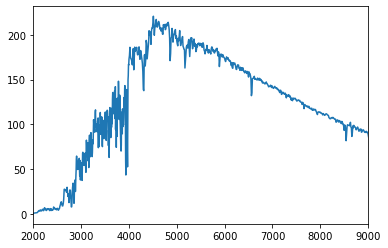

In [3]:
plt.plot(sun_spec.wave, sun_spec.flux)
plt.xlim(2000, 9000)

## Model & Atomic Data

In [4]:
def read_marcs(fname, atom_data):
    marcs_model1 = pd.read_csv(fname,skiprows=24, nrows=56, 
                               delim_whitespace=True, index_col='k')
    marcs_model2 = pd.read_csv(fname,skiprows=81, nrows=56, 
                               delim_whitespace=True, index_col='k')
    del marcs_model2['lgTauR']
    marcs_model = marcs_model1.join(marcs_model2)
    marcs_model.columns = [item.lower() for item in marcs_model.columns]
    marcs_model['lgtaur'] = 10**marcs_model['lgtaur']
    marcs_model['lgtau5'] = 10**marcs_model['lgtau5']
    
    marcs_model = marcs_model.rename(columns={'lgtaur':'tau_ref', 'lgtau5':'tau_500'})
    with open(fname) as fh:
        marcs_lines = fh.readlines()
    marcs_abundance_scale_str = ' '.join([item.strip() for item in marcs_lines[12:22]])
    marcs_abundances = pd.DataFrame(data=map(np.float64, marcs_abundance_scale_str.split()), columns=['abundance_scale'])
    marcs_abundances.replace({-99:np.nan}, inplace=True)
    marcs_abundances = marcs_abundances.set_index(np.arange(1, len(marcs_abundances)+1))
    marcs_abundances.index.name = 'atomic_number'
    marcs_abundances['mass_density'] = ((10**marcs_abundances['abundance_scale']) * 
                                        atom_data.atom_data.mass)
    marcs_abundances['mass_abundance'] = marcs_abundances['mass_density'] / marcs_abundances['mass_density'].sum()
    return marcs_model[::-1], marcs_abundances

# Converting model from finite difference to finite volume (cell boundaries to cells)
# Shape changes here because of averaging adjacent rows
def convert_marcs_finite_volume(marcs_model):
    marcs_model_fv = pd.DataFrame(data=0.5 * (marcs_model.iloc[:-1].values + marcs_model.iloc[1:].values), 
                                columns=marcs_model.columns)
    marcs_model_fv['r_inner'] = marcs_model['depth'].iloc[:-1].values
    marcs_model_fv['r_outer'] = marcs_model['depth'].iloc[1:].values
    marcs_model_fv['cell_length'] = -(marcs_model_fv['r_outer'].values - marcs_model_fv['r_inner'].values)
    return marcs_model_fv

In [5]:
adata = AtomData.from_hdf('kurucz_cd23_chianti_H_He.h5')
#adata.prepare_atom_data(marcs_abundances_all.index.tolist())
marcs_model, marcs_abundances_uniform = read_marcs('data/marcs/sun.mod', adata)
marcs_model

,tau_ref,tau_500,depth,t,pe,pg,prad,pturb,kappaross,density,mu,vconv,fconv/f,rhox
k,,,,,,,,,,,,,,
56,100.000000,58.979352,12340000.0,9934.3,8891.700000,218920.00,24.5560,0.0,78.748000,3.222400e-07,1.216,218200.0,0.97743,8.066432
55,63.095734,37.792011,10630000.0,9678.4,6792.000000,204310.00,22.1220,0.0,60.427000,3.110500e-07,1.225,226100.0,0.96002,7.525328
54,39.810717,24.372496,9171000.0,9424.6,5151.400000,192240.00,19.8900,0.0,45.965000,3.025700e-07,1.233,232200.0,0.94123,7.078444
53,25.118864,15.816122,7926000.0,9168.5,3857.700000,182180.00,17.8110,0.0,34.543000,2.964400e-07,1.240,237600.0,0.91188,6.705387
52,15.848932,10.318106,6851000.0,8903.8,2826.400000,173660.00,15.8380,0.0,25.489000,2.924300e-07,1.247,241200.0,0.86307,6.389028
51,10.000000,6.762387,5907000.0,8620.2,1994.300000,166280.00,13.8880,0.0,18.243000,2.904800e-07,1.252,242100.0,0.78270,6.113838
50,7.943282,5.482770,5478000.0,8462.6,1630.700000,162880.00,12.8690,0.0,15.097000,2.904200e-07,1.255,239900.0,0.71979,5.989352
49,6.309573,4.446313,5063000.0,8290.4,1299.800000,159590.00,11.8030,0.0,12.243000,2.910100e-07,1.257,233300.0,0.62604,5.868536
48,5.011872,3.604956,4651000.0,8097.7,999.240000,156320.00,10.6680,0.0,9.655300,2.923400e-07,1.259,220500.0,0.49909,5.748368


In [6]:
marcs_abundances_uniform['mass_abundance']

atomic_number
1     7.382733e-01
2     2.495226e-01
3     5.725908e-11
4     1.583425e-10
5     3.969481e-09
          ...     
88             NaN
89             NaN
90             NaN
91             NaN
92             NaN
Name: mass_abundance, Length: 92, dtype: float64

In [7]:
marcs_model_fv = convert_marcs_finite_volume(marcs_model)
marcs_model_fv

,tau_ref,tau_500,depth,t,pe,pg,prad,pturb,kappaross,density,mu,vconv,fconv/f,rhox,r_inner,r_outer,cell_length
0,81.547867,48.385682,11485000.0,9806.35,7841.850000,211615.000,23.33900,0.0,69.587500,3.166450e-07,1.2205,222150.00,0.968725,7.795880,12340000.0,10630000.0,1710000.0
1,51.453226,31.082253,9900500.0,9551.50,5971.700000,198275.000,21.00600,0.0,53.196000,3.068100e-07,1.2290,229150.00,0.950625,7.301886,10630000.0,9171000.0,1459000.0
2,32.464791,20.094309,8548500.0,9296.55,4504.550000,187210.000,18.85050,0.0,40.254000,2.995050e-07,1.2365,234900.00,0.926555,6.891915,9171000.0,7926000.0,1245000.0
3,20.483898,13.067114,7388500.0,9036.15,3342.050000,177920.000,16.82450,0.0,30.016000,2.944350e-07,1.2435,239400.00,0.887475,6.547207,7926000.0,6851000.0,1075000.0
4,12.924466,8.540247,6379000.0,8762.00,2410.350000,169970.000,14.86300,0.0,21.866000,2.914550e-07,1.2495,241650.00,0.822885,6.251433,6851000.0,5907000.0,944000.0
5,8.971641,6.122578,5692500.0,8541.40,1812.500000,164580.000,13.37850,0.0,16.670000,2.904500e-07,1.2535,241000.00,0.751245,6.051595,5907000.0,5478000.0,429000.0
6,7.126428,4.964541,5270500.0,8376.50,1465.250000,161235.000,12.33600,0.0,13.670000,2.907150e-07,1.2560,236600.00,0.672915,5.928944,5478000.0,5063000.0,415000.0
7,5.660723,4.025634,4857000.0,8194.05,1149.520000,157955.000,11.23550,0.0,10.949150,2.916750e-07,1.2580,226900.00,0.562565,5.808452,5063000.0,4651000.0,412000.0
8,4.496472,3.262536,4440000.0,7987.30,864.375000,154640.000,10.06380,0.0,8.488000,2.934600e-07,1.2600,209350.00,0.420700,5.686508,4651000.0,4229000.0,422000.0
9,3.571675,2.640025,4003500.0,7747.55,612.210000,151160.000,8.83360,0.0,6.291150,2.962100e-07,1.2620,180450.00,0.261050,5.557841,4229000.0,3778000.0,451000.0


In [8]:
marcs_abundances_all = pd.DataFrame(columns=marcs_model_fv.index.values, 
                    index=marcs_abundances_uniform.index)
for i in range(len(marcs_abundances_all.columns)):
    marcs_abundances_all[i] = marcs_abundances_uniform['mass_abundance']
#marcs_abundances_all = marcs_abundances_all.loc[30:1][::-1]

# pure hydrogen
marcs_abundances_all = marcs_abundances_all.iloc[[0]]
marcs_abundances_all.iloc[:] = 1.0

In [9]:
adata = AtomData.from_hdf('kurucz_cd23_chianti_H_He.h5')
adata.prepare_atom_data(marcs_abundances_all.index.tolist())

## Plasma

In [10]:
# Code that hasn't seen light of the day yet, might be useful in future

class InputNumberDensity(DataFrameInput):
    """
    Attributes
    ----------
    number_density : Pandas DataFrame, dtype float
                     Indexed by atomic number, columns corresponding to zones
    """

    outputs = ("number_density",)
    latex_name = ("N_{i}",)
    
class SelectedAtoms(ProcessingPlasmaProperty):
    """
    Attributes
    ----------
    selected_atoms : Pandas Int64Index, dtype int
                     Atomic numbers of elements required for particular simulation
    """

    outputs = ("selected_atoms",)

    def calculate(self, number_density):
        return number_density.index

def assemble_plasma(marcs_df):
    pass

In [11]:
#basic_properties.remove(tardis.plasma.properties.general.NumberDensity)
plasma_modules = []
plasma_modules += basic_inputs
plasma_modules += basic_properties
plasma_modules += lte_ionization_properties
plasma_modules += lte_excitation_properties
plasma_modules += non_nlte_properties

plasma_modules.append(tardis.plasma.properties.partition_function.LevelBoltzmannFactorNoNLTE)
plasma_modules.remove(tardis.plasma.properties.radiative_properties.TauSobolev)
plasma_modules.remove(tardis.plasma.properties.plasma_input.TimeExplosion)
plasma_modules.remove(tardis.plasma.properties.plasma_input.DilutionFactor)
plasma_modules.remove(tardis.plasma.properties.plasma_input.HeliumTreatment)
plasma_modules.remove(tardis.plasma.properties.plasma_input.ContinuumInteractionSpecies)
plasma_modules+= helium_lte_properties
plasma_modules.append(AlphaLine)
plasma_modules.append(HMinusDensity)
plasma_modules.append(TracingNus)
#plasma_modules.remove(tardis.plasma.properties.radiative_properties.StimulatedEmissionFactor)

#plasma_modules.remove(tardis.plasma.properties.general.SelectedAtoms)
#plasma_modules.remove(tardis.plasma.properties.plasma_input.Density)


In [12]:
tracing_wavelength = np.arange(2000, 10000, 0.01) * u.Angstrom
tracing_nus = tracing_wavelength.to(u.Hz, u.spectral())

splasma = BasePlasma(
        plasma_properties=plasma_modules,
        t_rad=marcs_model_fv.t.values, abundance=marcs_abundances_all,
        atomic_data=adata, 
        density=marcs_model_fv.density.values,
        link_t_rad_t_electron=1.0,
        tracing_nus=tracing_nus 
        )

## RT Calculation

In [13]:
tau_h_minus = calc_tau_h_minus(
    h_neutral_density=splasma.ion_number_density.loc[(1, 0)].values,
    temperature=marcs_model_fv.t.values * u.K,
    electron_density=splasma.electron_densities.values,
    wbr_fpath="data/wishart_broad_reinhardt_cross_section.dat",
    tracing_wavelength=tracing_wavelength.value,
    cell_length=marcs_model_fv.cell_length.values,
)
tau_h_minus

array([[5.09089067e+00, 5.09092571e+00, 5.09096076e+00, ...,
        2.04056107e+01, 2.04055969e+01, 2.04055832e+01],
       [3.52815785e+00, 3.52818214e+00, 3.52820643e+00, ...,
        1.41417721e+01, 1.41417626e+01, 1.41417530e+01],
       [2.44462760e+00, 2.44464443e+00, 2.44466126e+00, ...,
        9.79870172e+00, 9.79869510e+00, 9.79868848e+00],
       ...,
       [4.45577327e-07, 4.45580395e-07, 4.45583462e-07, ...,
        1.78598954e-06, 1.78598834e-06, 1.78598713e-06],
       [2.58919597e-07, 2.58921379e-07, 2.58923162e-07, ...,
        1.03781693e-06, 1.03781622e-06, 1.03781552e-06],
       [1.51410856e-07, 1.51411899e-07, 1.51412941e-07, ...,
        6.06893999e-07, 6.06893589e-07, 6.06893179e-07]])

In [14]:
# alpha value (=n x sigma) of each line for all 55 cells
# shape of splasma.alpha_line: (74, 55), splasma has 74 lines (aka atomic transitions)
alpha_line = splasma.alpha_line.reset_index(drop=True).values[::-1]
delta_tau_lines = alpha_line * marcs_model_fv.cell_length.values # shape: (74, 55)

In [15]:
tau_h_minus

array([[5.09089067e+00, 5.09092571e+00, 5.09096076e+00, ...,
        2.04056107e+01, 2.04055969e+01, 2.04055832e+01],
       [3.52815785e+00, 3.52818214e+00, 3.52820643e+00, ...,
        1.41417721e+01, 1.41417626e+01, 1.41417530e+01],
       [2.44462760e+00, 2.44464443e+00, 2.44466126e+00, ...,
        9.79870172e+00, 9.79869510e+00, 9.79868848e+00],
       ...,
       [4.45577327e-07, 4.45580395e-07, 4.45583462e-07, ...,
        1.78598954e-06, 1.78598834e-06, 1.78598713e-06],
       [2.58919597e-07, 2.58921379e-07, 2.58923162e-07, ...,
        1.03781693e-06, 1.03781622e-06, 1.03781552e-06],
       [1.51410856e-07, 1.51411899e-07, 1.51412941e-07, ...,
        6.06893999e-07, 6.06893589e-07, 6.06893179e-07]])

In [16]:
tau_h_minus.shape, delta_tau_lines.shape

((55, 800000), (74, 55))

In [17]:
# transition doesn't happen at a specific nu due to several factors (changing temperatures, doppler shifts, relativity, etc.)
# so we take a window 2e11 wide - if nu falls within that, we consider it

lines_nu = splasma.lines.nu.values[::-1] # reverse to bring them to ascending order

# search_sorted finds the index before which a (tracing_nu +- 1e11) can be inserted 
# in lines_nu array to maintain its sort order
line_id_starts = lines_nu.searchsorted(tracing_nus.value-1e11)
line_id_ends = lines_nu.searchsorted(tracing_nus.value+1e11)

### Source function

Can try taking this in lambda terms -> shouldn't sue to how RT eqn is solved

In [18]:
# bb shape: (56, 800000), calculated at each cell boundary
bb_prefactor = (2 * const.h.cgs * tracing_nus ** 3) / const.c.cgs ** 2
bb = bb_prefactor / (
    np.exp(
        (
            (const.h.cgs * tracing_nus)
            / (const.k_B.cgs * marcs_model.t.values[None].T * u.K)
        ).value
    )
    - 1
)


In [46]:
t_at_depth0 = marcs_model[marcs_model.depth==0].t.values[0]
t_at_depth0_idx = np.where(marcs_model.t.values==t_at_depth0)[0][0]
t_at_depth0_idx

15

In [72]:
bb.unit

Unit("erg Hz3 s3 / cm2")

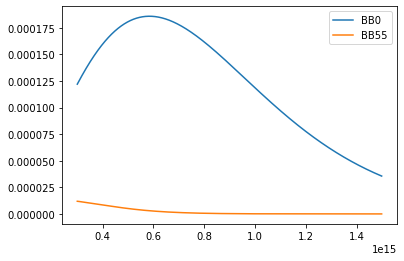

In [21]:
plt.plot(tracing_nus, bb.to("erg/(s*cm**2*Hz)")[0], label="BB0")
plt.plot(tracing_nus, bb.to("erg/(s*cm**2*Hz)")[55], label="BB55")
plt.legend()

In [22]:
bb_prefactor_wvl = (2 * const.h.cgs * const.c.cgs ** 2) / tracing_wavelength.to("cm") ** 5
bb_wvl = bb_prefactor_wvl / (
    np.exp(
        (
            (const.h.cgs * const.c.cgs)
            / (const.k_B.cgs * tracing_wavelength.to("cm") * marcs_model.t.values[None].T * u.K)
        ).value
    )
    - 1
)

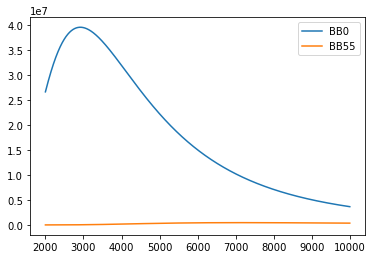

In [23]:
plt.plot(tracing_wavelength, bb_wvl.to("erg/(s*cm**2*AA)")[0], label="BB0")
plt.plot(tracing_wavelength, bb_wvl.to("erg/(s*cm**2*AA)")[55], label="BB55")
plt.legend()

In [24]:
marcs_model.t

k
56    9934.3
55    9678.4
54    9424.6
53    9168.5
52    8903.8
51    8620.2
50    8462.6
49    8290.4
48    8097.7
47    7876.9
46    7618.2
45    7314.8
44    6983.3
43    6694.8
42    6451.9
41    6235.2
40    6044.3
39    5875.7
38    5727.4
37    5597.1
36    5483.1
35    5382.5
34    5294.4
33    5216.8
32    5148.5
31    5088.6
30    5034.4
29    4988.1
28    4944.1
27    4905.9
26    4870.5
25    4838.3
24    4808.6
23    4780.9
22    4754.7
21    4729.9
20    4706.0
19    4682.9
18    4660.2
17    4637.8
16    4615.6
15    4593.5
14    4571.5
13    4549.5
12    4527.4
11    4504.9
10    4461.0
9     4416.3
8     4371.3
7     4326.1
6     4280.8
5     4235.5
4     4190.4
3     4145.9
2     4102.6
1     4066.8
Name: t, dtype: float64

In [25]:
source = bb[1:].value
delta_source = bb.diff(axis=0).value  # for cells, not boundary


In [55]:
bb[0], bb[1], delta_source[0]

(<Quantity [3.55959357e-05, 3.55966915e-05, 3.55974473e-05, ...,
            1.22023882e-04, 1.22023747e-04, 1.22023612e-04] erg Hz3 s3 / cm2>,
 <Quantity [2.93895734e-05, 2.93902254e-05, 2.93908775e-05, ...,
            1.16099823e-04, 1.16099698e-04, 1.16099573e-04] erg Hz3 s3 / cm2>,
 array([-6.20636233e-06, -6.20646609e-06, -6.20656985e-06, ...,
        -5.92405860e-06, -5.92404880e-06, -5.92403901e-06]))

In [21]:
tracing_wavelength[np.argmax(bb*tracing_nus/tracing_wavelength, axis=1)]

<Quantity [2916.94, 2994.06, 3074.69, 3160.57, 3254.54, 3361.61, 3424.21,
           3495.34, 3578.51, 3678.82, 3803.75, 3961.52, 4149.58, 4328.39,
           4491.35, 4647.44, 4794.22, 4931.79, 5059.49, 5177.28, 5284.92,
           5383.69, 5473.28, 5554.69, 5628.38, 5694.64, 5755.94, 5809.37,
           5861.07, 5906.71, 5949.64, 5989.24, 6026.23, 6061.15, 6094.54,
           6126.5 , 6157.61, 6187.99, 6218.13, 6248.16, 6278.21, 6308.42,
           6338.78, 6369.43, 6400.52, 6432.49, 6495.79, 6561.54, 6629.09,
           6698.35, 6769.23, 6841.63, 6915.27, 6989.49, 7063.26, 7125.44] Angstrom>

### RT Equation

In [68]:
# I_nu (specific intensity) is calculated at each cell boundary, shape: (56,800000)
# I_nu = np.ones((delta_tau_lines.shape[1] + 1, len(tracing_nus))) * -99
I_nu_wo_H = np.zeros((delta_tau_lines.shape[1] + 1, len(tracing_nus)))

I_nu_wo_H[0] = bb[0]  # the innermost boundary is photosphere
num_of_shells = len(I_nu_wo_H) - 1

for i in range(len(tracing_nus)):  # iterating over nus (columns)
    nu, line_id_start, line_id_end = (
        tracing_nus[i],
        line_id_starts[i],
        line_id_ends[i],
    )

    if line_id_start != line_id_end:
        delta_tau = delta_tau_lines[line_id_start:line_id_end]
        delta_nu = nu.value - lines_nu[line_id_start:line_id_end]
        tau_nus = calc_tau_nus(delta_tau, delta_nu)

    else:
        tau_nus = np.zeros(I_nu_wo_H.shape[0] - 1)

    for j in range(num_of_shells):  # iterating over cells/shells (rows)
        cur_tau_h_minus = 0.0
        # cur_tau_h_minus = tau_h_minus[j,i] 
        delta_tau_nu = tau_nus[j] + cur_tau_h_minus 
        w0, w1 = calc_weights(delta_tau_nu) 

        if tau_nus[j] == 0:
            second_term = 0
        else:
            # delta_source[j, i] = bb[j+1, i] - bb[j]
            second_term = w1 * delta_source[j, i] / delta_tau_nu

        # source[j,i] = bb[j+1, i]
        I_nu_wo_H[j + 1, i] = (1 - w0) * I_nu_wo_H[j, i] + w0 * bb.value[j+1, i] + second_term


In [57]:
# I_nu (specific intensity) is calculated at each cell boundary, shape: (56,800000)
# I_nu = np.ones((delta_tau_lines.shape[1] + 1, len(tracing_nus))) * -99
I_nu = np.zeros((delta_tau_lines.shape[1] + 1, len(tracing_nus)))

I_nu[0] = bb[0]  # the innermost boundary is photosphere
num_of_shells = len(I_nu) - 1

for i in range(len(tracing_nus)):  # iterating over nus (columns)
    nu, line_id_start, line_id_end = (
        tracing_nus[i],
        line_id_starts[i],
        line_id_ends[i],
    )

    if line_id_start != line_id_end:
        delta_tau = delta_tau_lines[line_id_start:line_id_end]
        delta_nu = nu.value - lines_nu[line_id_start:line_id_end]
        tau_nus = calc_tau_nus(delta_tau, delta_nu)

    else:
        tau_nus = np.zeros(I_nu.shape[0] - 1)

    for j in range(num_of_shells):  # iterating over cells/shells (rows)
        # cur_tau_h_minus = 0.0
        cur_tau_h_minus = tau_h_minus[j,i] 
        delta_tau_nu = tau_nus[j] + cur_tau_h_minus 
        w0, w1 = calc_weights(delta_tau_nu) 

        if tau_nus[j] == 0:
            second_term = 0
        else:
            # delta_source[j, i] = bb[j+1, i] - bb[j]
            second_term = w1 * delta_source[j, i] / delta_tau_nu

        # source[j,i] = bb[j+1, i]
        I_nu[j + 1, i] = (1 - w0) * I_nu[j, i] + w0 * bb.value[j+1, i] + second_term


### Plotting

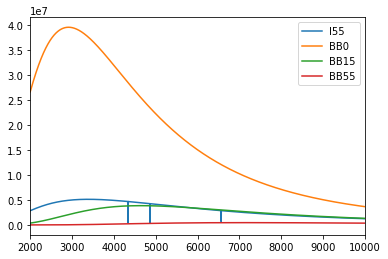

In [58]:
I_lambda = (I_nu[55])*tracing_nus/tracing_wavelength

plt.plot(tracing_wavelength, I_lambda, label="I55")
plt.plot(tracing_wavelength, bb[0]*tracing_nus/tracing_wavelength, label="BB0")
plt.plot(tracing_wavelength, bb[t_at_depth0_idx]*tracing_nus/tracing_wavelength, label=f"BB{t_at_depth0_idx}")
plt.plot(tracing_wavelength, bb[55]*tracing_nus/tracing_wavelength, label="BB55")
# plt.plot(tracing_wavelength, I_nu[0]*tracing_nus/tracing_wavelength, label="I0")
# plt.xlim(4330,4350) # to see 1st feature
# plt.xlim(6500, 6600) # to see last feature
plt.xlim(2000,10000) 
plt.legend()

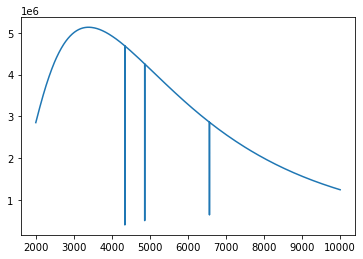

In [54]:
plt.plot(tracing_wavelength, ndimage.gaussian_filter1d(I_lambda,3))

In [51]:
bb_lambda_at_depth0_temp = bb[t_at_depth0_idx]*tracing_nus/tracing_wavelength

In [69]:
I_lambda_wo_H = (I_nu_wo_H[55])*tracing_nus/tracing_wavelength

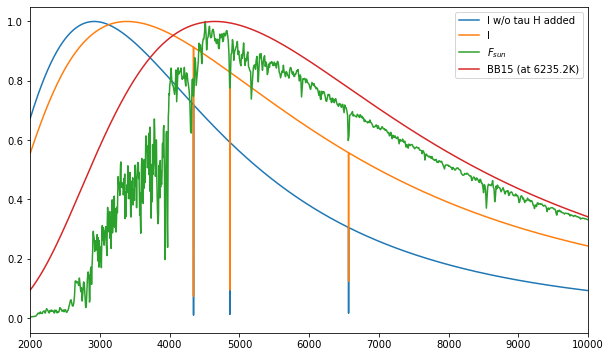

In [71]:
plt.figure(figsize=(10,6))
plt.plot(tracing_wavelength, I_lambda_wo_H/I_lambda_wo_H.max(), label="I w/o tau H added")
plt.plot(tracing_wavelength, I_lambda/I_lambda.max(), label="I")
plt.plot(sun_spec.wave, sun_spec.flux/sun_spec.flux.max(), label="$F_{sun}$")
plt.plot(tracing_wavelength, bb_lambda_at_depth0_temp/bb_lambda_at_depth0_temp.max(), label=f"BB{t_at_depth0_idx} (at {t_at_depth0}K)")

plt.xlim((2000,10000))
plt.legend()

### Start from BB15

In [62]:
# I_nu (specific intensity) is calculated at each cell boundary, shape: (56,800000)
# I_nu = np.ones((delta_tau_lines.shape[1] + 1, len(tracing_nus))) * -99
I_nu15 = np.zeros((delta_tau_lines.shape[1]-15 + 1, len(tracing_nus)))

I_nu15[0] = bb.value[15]  # the innermost boundary is photosphere
num_of_shells = len(I_nu15) - 1

for i in range(len(tracing_nus)):  # iterating over nus (columns)
    nu, line_id_start, line_id_end = (
        tracing_nus[i],
        line_id_starts[i],
        line_id_ends[i],
    )

    if line_id_start != line_id_end:
        delta_tau = delta_tau_lines[line_id_start:line_id_end]
        delta_nu = nu.value - lines_nu[line_id_start:line_id_end]
        tau_nus = calc_tau_nus(delta_tau, delta_nu)

    else:
        tau_nus = np.zeros(I_nu15.shape[0] - 1)

    for j in range(num_of_shells):  # iterating over cells/shells (rows)
        # cur_tau_h_minus = 0.0
        cur_tau_h_minus = tau_h_minus[15+j,i] 
        delta_tau_nu = tau_nus[j] + cur_tau_h_minus 
        w0, w1 = calc_weights(delta_tau_nu) 

        if tau_nus[j] == 0:
            second_term = 0
        else:
            # delta_source[j, i] = bb[j+1, i] - bb[j]
            second_term = w1 * (bb.value[15+j+1, i] - bb.value[15+j, i]) / delta_tau_nu

        # source[j,i] = bb[j+1, i]
        I_nu15[j + 1, i] = (1 - w0) * I_nu15[j, i] + w0 * bb.value[15+j+1, i] + second_term


In [66]:
I_lambda15 = (I_nu15[55-15])*tracing_nus/tracing_wavelength

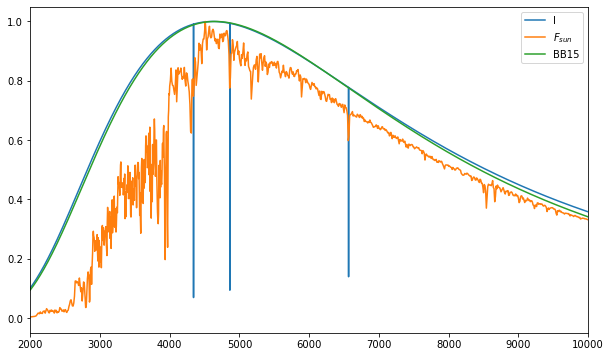

In [67]:
plt.figure(figsize=(10,6))
plt.plot(tracing_wavelength, I_lambda15/I_lambda15.max(), label="I")
plt.plot(sun_spec.wave, sun_spec.flux/sun_spec.flux.max(), label="$F_{sun}$")
plt.plot(tracing_wavelength, bb_lambda_at_depth0_temp/bb_lambda_at_depth0_temp.max(), label=f"BB{t_at_depth0_idx}")


plt.xlim((2000,10000))
plt.legend()

If this causes peaks to match, why are we calculating below depth 0? Will this shift the peak to right too as we add more taus?
-> no very clear but we gotta do from innermost that's why from inner and also because photosphere isn't fixed in gaseous surfaces of stars

